In [468]:
import copy
import joblib
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, f1_score
from sklearn.manifold import TSNE
from torch.nn import BCELoss, BCEWithLogitsLoss, Sequential, LeakyReLU, Linear
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
from sklearn.metrics.cluster import homogeneity_score, v_measure_score
# from torch_explain.nn import ConceptEmbeddings, context, semantics
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything
# from torch_explain.nn.vector_logic import NeSyLayer, to_boolean

# parameters for data, model, and training
cv = 3
emb_sizes = [2, 10, 50]
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
figsize = [9, 4]
# palette = [sns.color_palette("Paired")[i] for i in [5, 3]]
palette = [sns.color_palette("Paired")[i] for i in [5, 2, 3, 6, 7]]
# palette = [sns.color_palette("Paired")[i] for i in [5, 2, 6, 7]]
step = 500

experiments = {
#     'CelebA': '/local/scratch/me466/results/celeba_activations/test_embedding_acts/',
#     'CUB*': './results/cub_activations_expr_sub/test_embedding_acts/',
#     'CUB': './results/cub_activations_expr/test_embedding_acts/',
    'Dot': './results/toy_activations_expr/test_embedding_acts/',
#     'Trigonometry': './results/trig_activations_expr/test_embedding_acts/',
}
methods = {
    'SplitEmbModel': 'Split Embedding',
    'MaskedSplitEmbModelBounded': 'Masked Bounded Embedding',
    'ConceptBottleneckModelFuzzyExtraCapacity': 'Fuzzy+',
    'ConceptBottleneckModelFuzzy': 'Fuzzy', 
    'ConceptBottleneckModelBool': 'Bool'
}

In [469]:
def auc_truth_table_score(c_vec, c_test, y_test, step):
    n_clusters = np.arange(2, len(c_vec), step)
    max_auc = np.trapz(np.ones(len(n_clusters)))
#     n_clusters = 20
#     max_auc = np.trapz(np.ones(n_clusters))
    
    concept_auc, task_auc = [], []
    for concept_id in range(c_test.shape[1]):
        concept_homogeneity, task_homogeneity = [], []
        for nc in n_clusters:
#         for nc in [5, 10, 20]:
            kmedoids = KMedoids(n_clusters=nc, random_state=0)
            if c_vec.shape[1] != c_test.shape[1]:
                c_cluster_labels = kmedoids.fit_predict(c_vec)
            elif c_vec.shape[1] == c_test.shape[1] and len(c_vec.shape) == 2:
                c_cluster_labels = kmedoids.fit_predict(c_vec[:, concept_id].reshape(-1, 1))
            else:
                c_cluster_labels = kmedoids.fit_predict(c_vec[:, concept_id])
            concept_homogeneity.append(homogeneity_score(c_test[:, concept_id], c_cluster_labels))
            task_homogeneity.append(homogeneity_score(y_test, c_cluster_labels))

        concept_homogeneity = np.array(concept_homogeneity)
        concept_auc.append(np.trapz(concept_homogeneity) / max_auc)
        task_homogeneity = np.array(task_homogeneity)
        task_auc.append(np.trapz(task_homogeneity) / max_auc)
    
    concept_auc = np.mean(concept_auc)
    task_auc = np.mean(task_auc)
    return concept_auc, task_auc

In [470]:
for experiment_name, result_dir in experiments.items():
    c_test = np.load(os.path.join(result_dir, 'c_test.npy'))
    y_test = np.load(os.path.join(result_dir, 'y_test.npy'))
    results = pd.DataFrame()
    auc_scores = pd.DataFrame()
    columns = ['concept AUC (%)', 'task AUC (%)', 'method', 'fold']
    resnet = ''
    epochs = 3100
    if experiment_name == 'CUB':
        resnet = '_resnet34'
        epochs = 250
    elif experiment_name == 'CUB*':
        resnet = '_subsample_0.05_resnet34'
        epochs = 250
    elif experiment_name == 'CelebA':
        resnet = '_resnet34'
        epochs = 200
    
    for method, method_name in methods.items():
        for fold in range(cv):
#             fold = 1
            print(experiment_name, result_dir, method, fold+1)
            
#             print(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_semantics_on_epoch_{epochs}.npy'))
            c_pred = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_semantics_on_epoch_{epochs}.npy'))
            c_vec = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_vectors_on_epoch_{epochs}.npy'))
            y_pred = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_model_output_on_epoch_{epochs}.npy'))
            
            if experiment_name == 'CUB*':
                c_test = np.load(os.path.join(result_dir, 'c_test.npy'))
                selected_concepts = np.load(f"./results/cub_activations_expr_sub/selected_concepts_sampling_0.05_fold_{fold}.npy")
                c_test = c_test[:, selected_concepts]
            
            if method_name == 'Fuzzy+':
                c_vec = c_vec[:, c_test.shape[1]:]
            elif method_name in ['Split Embedding', 'Masked Bounded Embedding']:
                c_vec = c_vec.reshape(c_test.shape[0], c_test.shape[1], -1)[:, :, :-1]
            
            concept_auc, task_auc = auc_truth_table_score(c_vec, c_test, y_test, step)
            auc_scores = auc_scores.append(pd.DataFrame([[concept_auc, task_auc, method_name, fold]], columns=columns))
#             break
#         break
    break

Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModel 1
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModel 2
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModel 3
Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 2
Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 17 is empty! self.labels_[self.medoid_indices_[17]] may not be labeled with its corresponding cluster (17).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 35 is empty! self.labels_[self.medoid_indices_[35]] may not be labeled with its corresponding cluster (35).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 45 is empty! self.labels_[self.medoid_indices_[45]] may not be labeled with its corresponding cluster (45).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 46 is empty! self.labels_[self.medoid_indices_[46]] may not be labeled with its corresponding cluster (46).
  warnings.warn(
C:\Users\pietr\anaconda3

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 1
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 3
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 1
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 17 is empty! self.labels_[self.medoid_indices_[17]] may not be labeled with its corresponding cluster (17).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 35 is empty! self.labels_[self.medoid_indices_[35]] may not be labeled with its corresponding cluster (35).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 45 is empty! self.labels_[self.medoid_indices_[45]] may not be labeled with its corresponding cluster (45).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 49 is empty! self.labels_[self.medoid_indices_[49]] may not be labeled with its corresponding cluster (49).
  warnings.warn(
C:\Users\pietr\anaconda3

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 17 is empty! self.labels_[self.medoid_indices_[17]] may not be labeled with its corresponding cluster (17).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 35 is empty! self.labels_[self.medoid_indices_[35]] may not be labeled with its corresponding cluster (35).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 45 is empty! self.labels_[self.medoid_indices_[45]] may not be labeled with its corresponding cluster (45).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 51 is empty! self.labels_[self.medoid_indices_[51]] may not be labeled with its corresponding cluster (51).
  warnings.warn(
C:\Users\pietr\anaconda3

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 1
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 339 is empty! self.labels_[self.medoid_indices_[339]] may not be labeled with its corresponding cluster (339).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 340 is empty! self.labels_[self.medoid_indices_[340]] may not be labeled with its corresponding cluster (340).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 343 is empty! self.labels_[self.medoid_indices_[343]] may not be labeled with its corresponding cluster (343).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 345 is empty! self.labels_[self.medoid_indices_[345]] may not be labeled with its corresponding cluster (345).
  warnings.warn(
C:\Users\pie

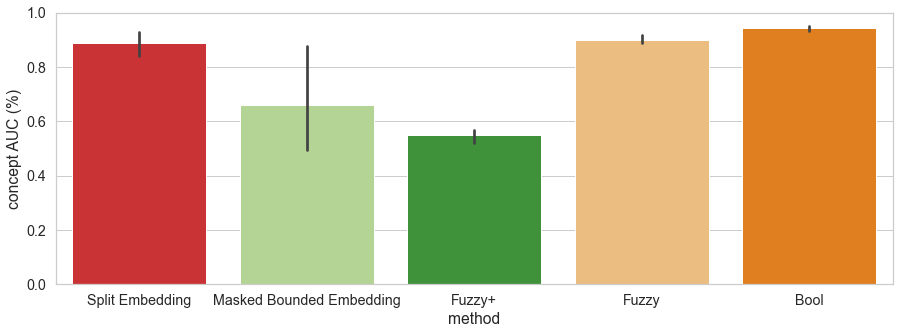

In [471]:
plt.figure(figsize=[15, 5])
sns.barplot(data=auc_scores, x='method', y='concept AUC (%)', palette=palette)
plt.ylim([0, 1])
plt.show()

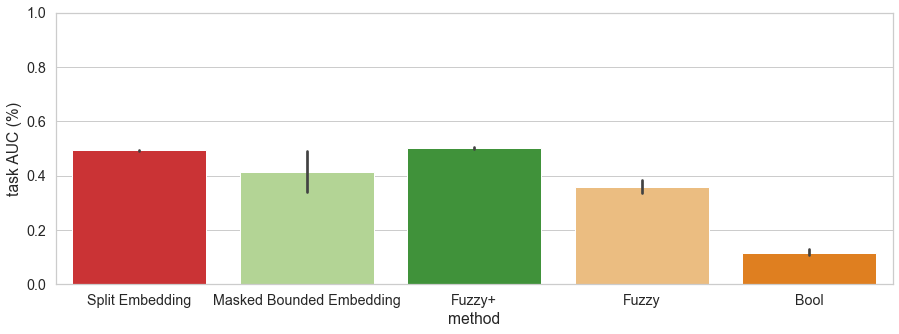

In [472]:
plt.figure(figsize=[15, 5])
sns.barplot(data=auc_scores, x='method', y='task AUC (%)', palette=palette)
plt.ylim([0, 1])
plt.show()

In [178]:
auc_scores

,concept AUC (%),task AUC (%),method,fold
0,0.698640,0.697002,Split Embedding,0
0,0.696188,0.701784,Split Embedding,1
0,0.723281,0.704278,Split Embedding,2
0,0.580802,0.610152,Masked Bounded Embedding,0
0,0.643043,0.673797,Masked Bounded Embedding,1
0,0.562814,0.629639,Masked Bounded Embedding,2
0,0.658421,0.694366,Fuzzy+,0
0,0.455517,0.579459,Fuzzy+,1
0,0.568238,0.652939,Fuzzy+,2
0,0.557023,0.581817,Fuzzy,0


In [229]:
selected_concepts = np.load(f"./results/cub_activations_expr_sub/selected_concepts_sampling_0.05_fold_2.npy")
selected_concepts

array([ 91,  44,  56,  82,  69, 103], dtype=int64)

In [227]:
selected_attributes = [
    1,
    4,
    6,
    7,
    10,
    14,
    15,
    20,
    21,
    23,
    25,
    29,
    30,
    35,
    36,
    38,
    40,
    44,
    45,
    50,
    51,
    53,
    54,
    56,
    57,
    59,
    63,
    64,
    69,
    70,
    72,
    75,
    80,
    84,
    90,
    91,
    93,
    99,
    101,
    106,
    110,
    111,
    116,
    117,
    119,
    125,
    126,
    131,
    132,
    134,
    145,
    149,
    151,
    152,
    153,
    157,
    158,
    163,
    164,
    168,
    172,
    178,
    179,
    181,
    183,
    187,
    188,
    193,
    194,
    196,
    198,
    202,
    203,
    208,
    209,
    211,
    212,
    213,
    218,
    220,
    221,
    225,
    235,
    236,
    238,
    239,
    240,
    242,
    243,
    244,
    249,
    253,
    254,
    259,
    260,
    262,
    268,
    274,
    277,
    283,
    289,
    292,
    293,
    294,
    298,
    299,
    304,
    305,
    308,
    309,
    310,
    311,
]


attributes = [
    "has_bill_shape::curved_(up_or_down)",
    "has_bill_shape::dagger",
    "has_bill_shape::hooked",
    "has_bill_shape::needle",
    "has_bill_shape::hooked_seabird",
    "has_bill_shape::spatulate",
    "has_bill_shape::all-purpose",
    "has_bill_shape::cone",
    "has_bill_shape::specialized",
    "has_wing_color::blue",
    "has_wing_color::brown",
    "has_wing_color::iridescent",
    "has_wing_color::purple",
    "has_wing_color::rufous",
    "has_wing_color::grey",
    "has_wing_color::yellow",
    "has_wing_color::olive",
    "has_wing_color::green",
    "has_wing_color::pink",
    "has_wing_color::orange",
    "has_wing_color::black",
    "has_wing_color::white",
    "has_wing_color::red",
    "has_wing_color::buff",
    "has_upperparts_color::blue",
    "has_upperparts_color::brown",
    "has_upperparts_color::iridescent",
    "has_upperparts_color::purple",
    "has_upperparts_color::rufous",
    "has_upperparts_color::grey",
    "has_upperparts_color::yellow",
    "has_upperparts_color::olive",
    "has_upperparts_color::green",
    "has_upperparts_color::pink",
    "has_upperparts_color::orange",
    "has_upperparts_color::black",
    "has_upperparts_color::white",
    "has_upperparts_color::red",
    "has_upperparts_color::buff",
    "has_underparts_color::blue",
    "has_underparts_color::brown",
    "has_underparts_color::iridescent",
    "has_underparts_color::purple",
    "has_underparts_color::rufous",
    "has_underparts_color::grey",
    "has_underparts_color::yellow",
    "has_underparts_color::olive",
    "has_underparts_color::green",
    "has_underparts_color::pink",
    "has_underparts_color::orange",
    "has_underparts_color::black",
    "has_underparts_color::white",
    "has_underparts_color::red",
    "has_underparts_color::buff",
    "has_breast_pattern::solid",
    "has_breast_pattern::spotted",
    "has_breast_pattern::striped",
    "has_breast_pattern::multi-colored",
    "has_back_color::blue",
    "has_back_color::brown",
    "has_back_color::iridescent",
    "has_back_color::purple",
    "has_back_color::rufous",
    "has_back_color::grey",
    "has_back_color::yellow",
    "has_back_color::olive",
    "has_back_color::green",
    "has_back_color::pink",
    "has_back_color::orange",
    "has_back_color::black",
    "has_back_color::white",
    "has_back_color::red",
    "has_back_color::buff",
    "has_tail_shape::forked_tail",
    "has_tail_shape::rounded_tail",
    "has_tail_shape::notched_tail",
    "has_tail_shape::fan-shaped_tail",
    "has_tail_shape::pointed_tail",
    "has_tail_shape::squared_tail",
    "has_upper_tail_color::blue",
    "has_upper_tail_color::brown",
    "has_upper_tail_color::iridescent",
    "has_upper_tail_color::purple",
    "has_upper_tail_color::rufous",
    "has_upper_tail_color::grey",
    "has_upper_tail_color::yellow",
    "has_upper_tail_color::olive",
    "has_upper_tail_color::green",
    "has_upper_tail_color::pink",
    "has_upper_tail_color::orange",
    "has_upper_tail_color::black",
    "has_upper_tail_color::white",
    "has_upper_tail_color::red",
    "has_upper_tail_color::buff",
    "has_head_pattern::spotted",
    "has_head_pattern::malar",
    "has_head_pattern::crested",
    "has_head_pattern::masked",
    "has_head_pattern::unique_pattern",
    "has_head_pattern::eyebrow",
    "has_head_pattern::eyering",
    "has_head_pattern::plain",
    "has_head_pattern::eyeline",
    "has_head_pattern::striped",
    "has_head_pattern::capped",
    "has_breast_color::blue",
    "has_breast_color::brown",
    "has_breast_color::iridescent",
    "has_breast_color::purple",
    "has_breast_color::rufous",
    "has_breast_color::grey",
    "has_breast_color::yellow",
    "has_breast_color::olive",
    "has_breast_color::green",
    "has_breast_color::pink",
    "has_breast_color::orange",
    "has_breast_color::black",
    "has_breast_color::white",
    "has_breast_color::red",
    "has_breast_color::buff",
    "has_throat_color::blue",
    "has_throat_color::brown",
    "has_throat_color::iridescent",
    "has_throat_color::purple",
    "has_throat_color::rufous",
    "has_throat_color::grey",
    "has_throat_color::yellow",
    "has_throat_color::olive",
    "has_throat_color::green",
    "has_throat_color::pink",
    "has_throat_color::orange",
    "has_throat_color::black",
    "has_throat_color::white",
    "has_throat_color::red",
    "has_throat_color::buff",
    "has_eye_color::blue",
    "has_eye_color::brown",
    "has_eye_color::purple",
    "has_eye_color::rufous",
    "has_eye_color::grey",
    "has_eye_color::yellow",
    "has_eye_color::olive",
    "has_eye_color::green",
    "has_eye_color::pink",
    "has_eye_color::orange",
    "has_eye_color::black",
    "has_eye_color::white",
    "has_eye_color::red",
    "has_eye_color::buff",
    "has_bill_length::about_the_same_as_head",
    "has_bill_length::longer_than_head",
    "has_bill_length::shorter_than_head",
    "has_forehead_color::blue",
    "has_forehead_color::brown",
    "has_forehead_color::iridescent",
    "has_forehead_color::purple",
    "has_forehead_color::rufous",
    "has_forehead_color::grey",
    "has_forehead_color::yellow",
    "has_forehead_color::olive",
    "has_forehead_color::green",
    "has_forehead_color::pink",
    "has_forehead_color::orange",
    "has_forehead_color::black",
    "has_forehead_color::white",
    "has_forehead_color::red",
    "has_forehead_color::buff",
    "has_under_tail_color::blue",
    "has_under_tail_color::brown",
    "has_under_tail_color::iridescent",
    "has_under_tail_color::purple",
    "has_under_tail_color::rufous",
    "has_under_tail_color::grey",
    "has_under_tail_color::yellow",
    "has_under_tail_color::olive",
    "has_under_tail_color::green",
    "has_under_tail_color::pink",
    "has_under_tail_color::orange",
    "has_under_tail_color::black",
    "has_under_tail_color::white",
    "has_under_tail_color::red",
    "has_under_tail_color::buff",
    "has_nape_color::blue",
    "has_nape_color::brown",
    "has_nape_color::iridescent",
    "has_nape_color::purple",
    "has_nape_color::rufous",
    "has_nape_color::grey",
    "has_nape_color::yellow",
    "has_nape_color::olive",
    "has_nape_color::green",
    "has_nape_color::pink",
    "has_nape_color::orange",
    "has_nape_color::black",
    "has_nape_color::white",
    "has_nape_color::red",
    "has_nape_color::buff",
    "has_belly_color::blue",
    "has_belly_color::brown",
    "has_belly_color::iridescent",
    "has_belly_color::purple",
    "has_belly_color::rufous",
    "has_belly_color::grey",
    "has_belly_color::yellow",
    "has_belly_color::olive",
    "has_belly_color::green",
    "has_belly_color::pink",
    "has_belly_color::orange",
    "has_belly_color::black",
    "has_belly_color::white",
    "has_belly_color::red",
    "has_belly_color::buff",
    "has_wing_shape::rounded-wings",
    "has_wing_shape::pointed-wings",
    "has_wing_shape::broad-wings",
    "has_wing_shape::tapered-wings",
    "has_wing_shape::long-wings",
    "has_size::large_(16_-_32_in)",
    "has_size::small_(5_-_9_in)",
    "has_size::very_large_(32_-_72_in)",
    "has_size::medium_(9_-_16_in)",
    "has_size::very_small_(3_-_5_in)",
    "has_shape::upright-perching_water-like",
    "has_shape::chicken-like-marsh",
    "has_shape::long-legged-like",
    "has_shape::duck-like",
    "has_shape::owl-like",
    "has_shape::gull-like",
    "has_shape::hummingbird-like",
    "has_shape::pigeon-like",
    "has_shape::tree-clinging-like",
    "has_shape::hawk-like",
    "has_shape::sandpiper-like",
    "has_shape::upland-ground-like",
    "has_shape::swallow-like",
    "has_shape::perching-like",
    "has_back_pattern::solid",
    "has_back_pattern::spotted",
    "has_back_pattern::striped",
    "has_back_pattern::multi-colored",
    "has_tail_pattern::solid",
    "has_tail_pattern::spotted",
    "has_tail_pattern::striped",
    "has_tail_pattern::multi-colored",
    "has_belly_pattern::solid",
    "has_belly_pattern::spotted",
    "has_belly_pattern::striped",
    "has_belly_pattern::multi-colored",
    "has_primary_color::blue",
    "has_primary_color::brown",
    "has_primary_color::iridescent",
    "has_primary_color::purple",
    "has_primary_color::rufous",
    "has_primary_color::grey",
    "has_primary_color::yellow",
    "has_primary_color::olive",
    "has_primary_color::green",
    "has_primary_color::pink",
    "has_primary_color::orange",
    "has_primary_color::black",
    "has_primary_color::white",
    "has_primary_color::red",
    "has_primary_color::buff",
    "has_leg_color::blue",
    "has_leg_color::brown",
    "has_leg_color::iridescent",
    "has_leg_color::purple",
    "has_leg_color::rufous",
    "has_leg_color::grey",
    "has_leg_color::yellow",
    "has_leg_color::olive",
    "has_leg_color::green",
    "has_leg_color::pink",
    "has_leg_color::orange",
    "has_leg_color::black",
    "has_leg_color::white",
    "has_leg_color::red",
    "has_leg_color::buff",
    "has_bill_color::blue",
    "has_bill_color::brown",
    "has_bill_color::iridescent",
    "has_bill_color::purple",
    "has_bill_color::rufous",
    "has_bill_color::grey",
    "has_bill_color::yellow",
    "has_bill_color::olive",
    "has_bill_color::green",
    "has_bill_color::pink",
    "has_bill_color::orange",
    "has_bill_color::black",
    "has_bill_color::white",
    "has_bill_color::red",
    "has_bill_color::buff",
    "has_crown_color::blue",
    "has_crown_color::brown",
    "has_crown_color::iridescent",
    "has_crown_color::purple",
    "has_crown_color::rufous",
    "has_crown_color::grey",
    "has_crown_color::yellow",
    "has_crown_color::olive",
    "has_crown_color::green",
    "has_crown_color::pink",
    "has_crown_color::orange",
    "has_crown_color::black",
    "has_crown_color::white",
    "has_crown_color::red",
    "has_crown_color::buff",
    "has_wing_pattern::solid",
    "has_wing_pattern::spotted",
    "has_wing_pattern::striped",
    "has_wing_pattern::multi-colored",
]

In [230]:
concept_semantics = list(np.array(attributes)[np.array(selected_attributes)[selected_concepts]])
concept_semantics

['has_primary_color::grey',
 'has_breast_color::buff',
 'has_forehead_color::yellow',
 'has_shape::perching-like',
 'has_nape_color::buff',
 'has_crown_color::brown']

In [234]:
subsample_c_test = []
for c in c_test:
    subsample_c_test.append(c)
subsample_c_test = np.concatenate(subsample_c_test, axis=0)
print("subsample_c_test.shape =", subsample_c_test.shape)

subsample_c_test.shape = (7188,)


In [265]:
n = 5794
[x for x in range(1, n+1) if n/x==int(n/x)]

[1, 2, 2897, 5794]

In [237]:
c_test.shape

(1198, 6)